In [1]:
import tensorflow as tf
import numpy as np
from spiking_models import DenseRNN, SpikingReLU, SpikingSigmoid, SpikingTanh, Accumulate
import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input, Model
from operations_layers import SqueezeLayer, ExpandLayer, MatMulLayer, MatMulLayerTranspose, TransposeLayer, \
    ExtractPatchesLayer, PositionalEncodingLayer, Tokpos

In [2]:
def get_normalized_weights(model, x_test, percentile=100):
    x_test = x_test[::10]
    max_activation = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.ReLU):
            activation = tf.keras.Model(inputs=model.inputs, outputs=layer.output)(x_test).numpy()
            if np.percentile(activation, percentile) > max_activation:
                max_activation = np.percentile(activation, percentile)
        elif isinstance(layer, tf.keras.layers.Dense):
            if layer.activation.__name__ == 'relu':
                activation = tf.keras.Model(inputs=model.inputs, outputs=layer.output)(x_test).numpy()
                if np.percentile(activation, percentile) > max_activation:
                    max_activation = np.percentile(activation, percentile)

    weights = model.get_weights()     
    if max_activation == 0:
        print("\n" + "-"*32 + "\nNo normalization\n" + "-"*32)
    else:
        print("\n" + "-"*32 + "\nNormalizing by", max_activation, "\n" + "-"*32)
        for i in range(len(weights)):
            weights[i] /= (max_activation)
    return weights


def evaluate_conversion(converted_model, original_model, x_test, y_test, testacc, timesteps=50):
    for i in range(1, timesteps+1):
        _, acc = converted_model.evaluate(x_test, y_test, batch_size=y_test.shape[0], verbose=0)
        print(
            "Timesteps", str(i) + "/" + str(timesteps) + " -",
            "acc spiking (orig): %.2f%% (%.2f%%)" % (acc*100, testacc*100),
            "- conv loss: %+.2f%%" % ((-(1 - acc/testacc)*100)))
        
def evaluate_conversion_and_save_data(converted_model, original_model, x_test, y_test, testacc, timesteps=50):
    accuracy_per_t = []
    for i in range(0, timesteps):
        _, acc = converted_model.evaluate(x_test, y_test, batch_size=y_test.shape[0], verbose=0)
        accuracy_per_t.append(acc)
        print(
            "Timesteps", str(i) + "/" + str(timesteps) + " -",
            "acc spiking (orig): %.2f%% (%.2f%%)" % (acc*100, testacc*100),
            "- conv loss: %+.2f%%" % ((-(1 - acc/testacc)*100)))
    return accuracy_per_t

In [3]:
def robust_weight_normalization(model, x_test, ppercentile=1):
    prev_factor = 1
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.ReLU) or (isinstance(layer, tf.keras.layers.Dense) and
                                                       layer.activation.__name__ == 'relu'):

            activation = tf.keras.Model(inputs=model.inputs, outputs=layer.output)(x_test).numpy()
            activation = tf.math.reduce_max(activation, axis=0)
            activation = tf.sort(activation)
            max_act = activation[int(ppercentile * (len(activation) - 1))]

            weights, bias = layer.get_weights()
            max_wt = max(0, tf.math.reduce_max(weights))
            max_bias = tf.math.reduce_max(bias)

            max_wt_bias = max(max_bias, max_wt)

            scale_factor = max(max_act, max_wt_bias)
            applied_factor = scale_factor / prev_factor

            weights = weights / applied_factor
            bias = bias / scale_factor

            prev_factor = scale_factor
            layer.set_weights([weights, bias])
            print(f"Scale factor for layer {layer}")
            print(f"{applied_factor}")

    return model

In [24]:
batch_size=64
epochs = 2
act='relu'

def create_ann_with_embedding():
    dv = 25
    nv = -1
    vocab_size = 20000  # Only consider the top 20k words
    maxlen = 200  # Only consider the first 200 words of each movie review
    embed_dim = 32  # Embedding size for each token
    num_classes = 2
    l = 50
    
    inputs = tf.keras.layers.Input(shape=(maxlen,))
#     x = Tokposangles()(inputs)
#     x = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=32)(inputs)
    x = Tokpos(maxlen, vocab_size, embed_dim)(inputs)
    
    # -------------- TRANSFORMER BLOCK -----------------
    v2 = tf.keras.layers.Dense(embed_dim)(x)
    q2 = tf.keras.layers.Dense(embed_dim)(x)
    k2 = tf.keras.layers.Dense(embed_dim)(x)

    v = tf.keras.layers.Reshape([embed_dim, nv, dv])(v2)
    q = tf.keras.layers.Reshape([embed_dim, nv, dv])(q2)
    k = tf.keras.layers.Reshape([embed_dim, nv, dv])(k2)

    # softmax(q*k^T/sqrt(dv))
    att = MatMulLayerTranspose()([q, k])
    # att = ScaleLayer()([att, np.sqrt(dv)])
    # TODO: observer if axis=-1 is not necessary
    att = tf.keras.layers.Softmax()(att)
    # softmax(q*k^T/sqrt(dv))*v
    out = MatMulLayer()([att, v])

    out = tf.keras.layers.Reshape([embed_dim, maxlen, 1])(out)
    x = tf.keras.layers.Reshape([embed_dim, maxlen, 1])(x)
    add = tf.keras.layers.Add()([out, x])
    # add = tf.add(out, x)
    
    x = tf.keras.layers.Flatten()(add)
    x = tf.keras.layers.Dense(embed_dim, activation="relu")(x)
    x = tf.keras.layers.Dense(embed_dim)(x)
    # --------------------------------------------------
    
#     x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x = tf.keras.layers.AveragePooling1D()(x)
    x = tf.keras.layers.Dense(l, activation="relu")(x)
    # --------------------------------------------------
    outputs = tf.keras.layers.Dense(num_classes)(x)
    outputs = tf.keras.layers.Softmax()(outputs)
    ann = tf.keras.Model(inputs=inputs, outputs=outputs)

    ann.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"])
    
#     ann.compile(
#         optimizer=tf.keras.optimizers.RMSprop(),
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#         metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    ann.fit(
        x_train,
        y_train,
        validation_data=(x_test, y_test),
        batch_size=batch_size,
        epochs=epochs)
    return ann

In [25]:
def convert_tailored(weights, y_test):
    dv = 25
    nv = -1
    vocab_size = 20000  # Only consider the top 20k words
    maxlen = 200  # Only consider the first 200 words of each movie review
    embed_dim = 32  # Embedding size for each token
    num_classes = 2
    l = 50
    
    inputs = tf.keras.layers.Input(shape=(1, maxlen,), batch_size=y_test.shape[0])
    x = Tokpos(maxlen, vocab_size, embed_dim)(inputs)
    
    # -------------- TRANSFORMER BLOCK -----------------

    v2 = tf.keras.layers.Dense(embed_dim)(x)
    q2 = tf.keras.layers.Dense(embed_dim)(x)
    k2 = tf.keras.layers.Dense(embed_dim)(x)

    v = tf.keras.layers.Reshape([embed_dim, nv, dv])(v2)
    q = tf.keras.layers.Reshape([embed_dim, nv, dv])(q2)
    k = tf.keras.layers.Reshape([embed_dim, nv, dv])(k2)

    # softmax(q*k^T/sqrt(dv))
    att = MatMulLayerTranspose()([q, k])
    # att = ScaleLayer()([att, np.sqrt(dv)])
    # TODO: observer if axis=-1 is not necessary
#     att = tf.keras.layers.Reshape([1, embed_dim*nv*dv])(att)
#     print(att.shape)
#     att = tf.keras.layers.RNN(Accumulate(embed_dim*dv), return_sequences=True, return_state=False, stateful=True)(att)
#     att = tf.keras.layers.Reshape([embed_dim, nv, dv])(att)
    att = tf.keras.layers.Softmax()(att)
    
    # softmax(q*k^T/sqrt(dv))*v
    out = MatMulLayer()([att, v])

    out = tf.keras.layers.Reshape([embed_dim, maxlen, 1])(out)
    x = tf.keras.layers.Reshape([embed_dim, maxlen, 1])(x)
    add = tf.keras.layers.Add()([out, x])
    # add = tf.add(out, x)
    
    x = tf.keras.layers.Flatten()(add)
    x = ExpandLayer()(x)
    x = tf.keras.layers.Dense(embed_dim)(x)
    x = tf.keras.layers.RNN(SpikingReLU(embed_dim), return_sequences=True, return_state=False, 
                            stateful=True)(x)
    x = tf.keras.layers.Dense(embed_dim)(x)
    # --------------------------------------------------
    
    x = tf.keras.layers.Dense(l)(x)
    x = tf.keras.layers.RNN(SpikingReLU(l), return_sequences=True, return_state=False, 
                            stateful=True)(x)
    # --------------------------------------------------
    x = tf.keras.layers.Dense(num_classes)(x)
    x = tf.keras.layers.RNN(Accumulate(num_classes), return_sequences=True, return_state=False, stateful=True)(x)
    x = tf.keras.layers.Softmax()(x)
    x = SqueezeLayer()(x)
    
    spiking = tf.keras.models.Model(inputs=inputs, outputs=x)
    
    print("-"*32 + "\n")
    spiking.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"])
    print(spiking.summary())
    spiking.set_weights(weights)
    return spiking

In [43]:
tf.random.set_seed(1234)
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_test), "Validation sequences")
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
# x_train = np.expand_dims(x_train, axis=1)  # (60000, 784) -> (60000, 1, 784)
# x_test = np.expand_dims(x_test, axis=1)

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

# Analog model
ann = create_ann_with_embedding()
print(ann.summary())

_, testacc = ann.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
# weights = ann.get_weights()
# weights = get_normalized_weights(ann, x_train, percentile=99)
model_normalized = robust_weight_normalization(ann, x_train, 0.99)
weights = model_normalized.get_weights()

##################################################
# Preprocessing for RNN 
x_train = np.expand_dims(x_train, axis=1)  # (60000, 784) -> (60000, 1, 784)
x_test = np.expand_dims(x_test, axis=1)

##################################################
# Conversion to spiking model
# snn = convert(ann, weights, x_test, y_test)
snn = convert_tailored(weights, y_test)
print("Start evaluation")
# evaluate_conversion(snn, ann, x_test, y_test, testacc, timesteps=50)
timesteps = 50
accuracy = evaluate_conversion_and_save_data(snn, ann, x_test, y_test, testacc, timesteps)

25000 Training sequences
25000 Validation sequences
Epoch 1/2
391/391 [==============================] - 7s 16ms/step - loss: 0.6313 - accuracy: 0.5751 - val_loss: 0.2955 - val_accuracy: 0.8742
Epoch 2/2
391/391 [==============================] - 6s 16ms/step - loss: 0.2071 - accuracy: 0.9187 - val_loss: 0.3097 - val_accuracy: 0.8742
Model: "model_56"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
tokpos_28 (Tokpos)              (None, 200, 32)      646400      input_29[0][0]                   
__________________________________________________________________________________________________
dense_197 (Dense)               (None, 200, 32)     

Text(0.5, 0, 'simulation time-steps')

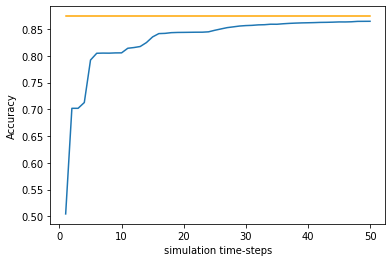

In [45]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(1, timesteps + 1), accuracy)
ax.plot(range(1, timesteps + 1), [testacc for i in range(1, timesteps + 1)], color="orange")
ax.set_ylabel('Accuracy')
ax.set_xlabel('simulation time-steps')